We here reduce the dimension of data through principal component analysis (PCA)
to apply the data to quantum machine learning.

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

We got information about some genes related to COVID-19 from the Kyoto Encyclopedia of Genes and Genomes (KEGG) database.
We also selected the same number of genes that are not related to COVID-19.
To analyze the gene expression levels, we will use the $\log_{2}$ fold change method.
Hence, in this process, we exclude genes if there are zeros in their data.

In [2]:
df = pd.read_csv('./GSE147507_Series6,16.csv', index_col=0)
df_covrelated = pd.read_csv('./GSE147507_Series6,16_covrelated.csv', index_col=0)

cov_related_genes = df_covrelated.index

drop_genes = []
for gene in cov_related_genes:
    if 0 in list(df.loc[gene, :]):
        drop_genes.append(gene)
cov_related_genes2 = [gene for gene in cov_related_genes if gene not in drop_genes]

not_related_genes = [x for x in df.index if x not in cov_related_genes2]
drop_genes = []
for gene in not_related_genes:
    if 0 in list(df.loc[gene, :]):
        drop_genes.append(gene)

n_related_genes = [x for x in not_related_genes if x not in drop_genes]


not_related_genes2 = random.sample([x for x in not_related_genes if x not in drop_genes], len(cov_related_genes2))

df_sample = df.loc[cov_related_genes2+not_related_genes2,:]
df_sample.to_csv('./GSE147507_sample.csv', index=True)

As mentioned earlier, we use the $\log_{2}$ fold change method.
We divide the number of genes infected with SARS-CoV-2
by the number of uninfected genes and apply the log function.

In [3]:
new_dict = {}
for gene in df_sample.index:
    Series6_1 = math.log(df_sample.loc[gene, 'Series6_A549-ACE2_SARS-CoV-2_1']/df_sample.loc[gene, 'Series6_A549-ACE2_Mock_1'], 2)
    Series6_2 = math.log(df_sample.loc[gene, 'Series6_A549-ACE2_SARS-CoV-2_2']/df_sample.loc[gene, 'Series6_A549-ACE2_Mock_2'], 2)
    Series6_3 = math.log(df_sample.loc[gene, 'Series6_A549-ACE2_SARS-CoV-2_3']/df_sample.loc[gene, 'Series6_A549-ACE2_Mock_3'], 2)
    Series16_1 = math.log(df_sample.loc[gene, 'Series16_A549-ACE2_SARS-CoV-2_1']/df_sample.loc[gene, 'Series16_A549-ACE2_Mock_1'], 2)
    Series16_2 = math.log(df_sample.loc[gene, 'Series16_A549-ACE2_SARS-CoV-2_2']/df_sample.loc[gene, 'Series16_A549-ACE2_Mock_2'], 2)
    Series16_3 = math.log(df_sample.loc[gene, 'Series16_A549-ACE2_SARS-CoV-2_3']/df_sample.loc[gene, 'Series16_A549-ACE2_Mock_3'], 2)
    
    if gene in cov_related_genes2:
        new_dict[gene] = [Series6_1, Series6_2, Series6_3, Series16_1, Series16_2, Series16_3, 1]
    else:
        new_dict[gene] = [Series6_1, Series6_2, Series6_3, Series16_1, Series16_2, Series16_3, 0]

In [4]:
df_div = pd.DataFrame.from_dict(new_dict).T
df_div.columns = ['Series6_1', 'Series6_2', 'Series6_3', 'Series16_1', 'Series16_2', 'Series16_3', 'Target']
df_div.to_csv('./GSE147507_sample_div.csv', index=True)

Below we plot a graph for the reduced-dimensional data.
We use PCA and set the number of components to two.


In [5]:
x = df_div.drop(['Target'], axis=1).values
y = df_div['Target'].values
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principaldf = pd.DataFrame(data=principalComponents, columns = ['pc1', 'pc2'])
principaldf['target'] = y
principaldf.index = df_div.index


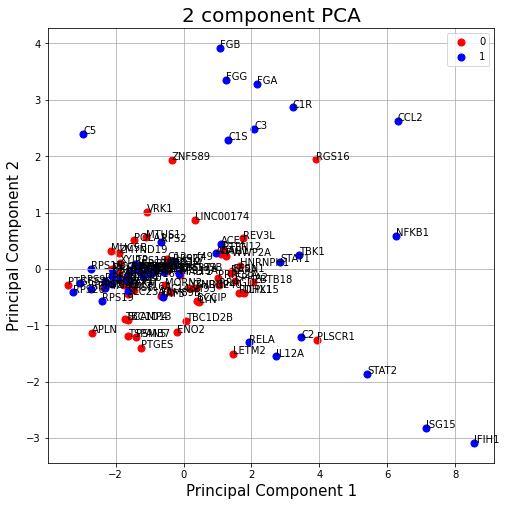

In [6]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets= [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principaldf['target'] == target
    ax.scatter(principaldf.loc[indicesToKeep, 'pc1'],
               principaldf.loc[indicesToKeep, 'pc2'],
               c = color,
               s = 50)
for i, gene in enumerate(principaldf.index.tolist()):
    ax.annotate(gene, (principaldf.loc[gene, 'pc1'], principaldf.loc[gene, 'pc2']))
ax.legend(targets)
ax.grid()

Although most genes are distributed near $(0,0)$,
we can distinguish several genes related to COVID-19 (blue dots).

In [7]:
fig.savefig('pca.png', dpi=300)

